<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/xai_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import Adam,SGD
from skimage.segmentation import mark_boundaries
from xml.etree import ElementTree

Model 22

In [34]:
saved_model = load_model('/content/drive/My Drive/xai_model/model_22.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [35]:
saved_model.layers[0].input_shape

(None, None, None, 3)

In [75]:
saved_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [0]:
annotation = '/content/drive/My Drive/NEU-DET/ANNOTATIONS/patches_279.xml'
image_path="/content/drive/My Drive/NEU surface defect database - test split/Test/Pa/Pa_279.bmp"

[[1.4354520e-02 1.5001049e-05 2.4510935e-05 9.8283225e-01 2.9171051e-06
  2.7708216e-03]]
Patches


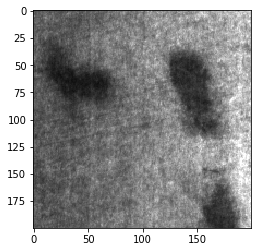

In [38]:
image_path_copy = image_path
img = image.load_img(image_path, target_size=(200,200))
b_img = cv2.imread(image_path)
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
result = saved_model.predict(img)
print(result)

prediction = result.argmax(axis=-1)

if prediction == 0:
  label = "Crazing" 
elif prediction == 1:
  label = "Inclusion"
elif prediction == 2:
  label = "Pitted Surface"
elif prediction == 3:
  label = "Patches"
elif prediction == 4:
  label = "Rolled-in scale"
elif prediction == 5:
  label = "Scratches"
else:
  label = "Exception"

print(label)

In [39]:
def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

boxes = extract_boxes(annotation)

print(boxes)


[[11, 33, 72, 81], [121, 32, 171, 116], [154, 153, 189, 199]]


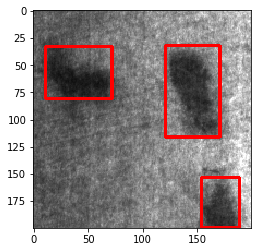

In [40]:
for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  #print(pt1, pt2)
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 2)
  plt.imshow(b_img)

In [41]:
!pip install lime

In [42]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
explainer = lime_image.LimeImageExplainer()

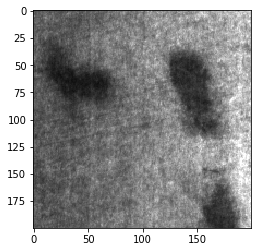

In [65]:
img = image.load_img(image_path_copy, target_size=(200,200))
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

In [45]:
%%time
# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(img[0], saved_model.predict, top_labels=5, hide_color=0)

CPU times: user 5.01 s, sys: 1.18 s, total: 6.19 s
Wall time: 5.96 s


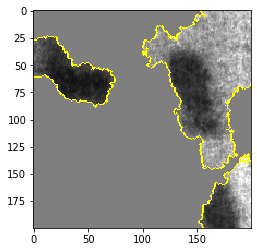

In [51]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

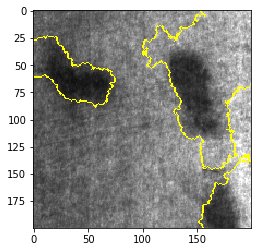

In [53]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
#plt.savefig('/content/drive/My Drive/XAI_results/LIME_Pa_279_2.jpg')

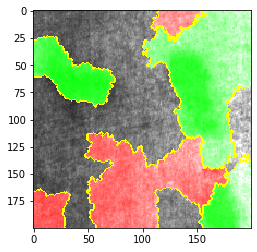

In [55]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
#plt.savefig('/content/drive/My Drive/XAI_results/LIME_Pa_279.jpg')

In [0]:
#temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False, min_weight=0.5)
#plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [54]:
pip install shap

     |████████████████████████████████| 266kB 3.5MB/s 
  Created wheel for shap: filename=shap-0.31.0-cp36-cp36m-linux_x86_64.whl size=375009 sha256=699fb145d985c56559de417c060469a4d8da16c66ed9e7b52655e3c3ba0880ad
  Stored in directory: /root/.cache/pip/wheels/7b/2d/46/ff8959add2e4e99a18a6e90b82f47508bf52fdf7e7d806f7df
Successfully built shap


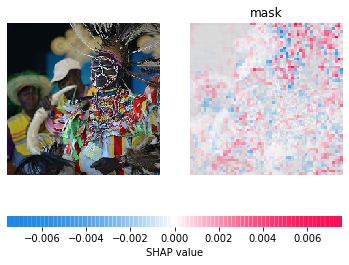

In [73]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[7]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=1)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [74]:
class_names

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


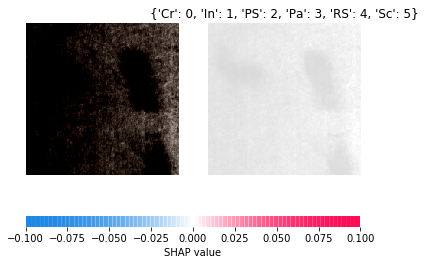

In [72]:
import keras.backend as K
import numpy as np
import shap

def map2layer(x, layer):
  feed_dict = dict(zip([saved_model.layers[0].input], [preprocess_input(x.copy())]))  
  return K.get_session().run(saved_model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((saved_model.layers[7].input, saved_model.layers[-1].output), map2layer(img, 7), local_smoothing=0)

shap_values, indexes = e.shap_values(map2layer(img, 7), ranked_outputs=1)

index_names = np.vectorize(lambda x: label_map)(indexes)

shap.image_plot(shap_values, img, index_names)


In [0]:
label_map = {'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}